# Validation programming exercise

In [41]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [29]:
def preprocess_features(california_housing_dataframe):
    """
    Prepares input features from California housing data set
    
    Args:
        california_housing_dataframe : Pandas DataFrame containing CA housing data
    Returns:
        Pandas DataFrame containing features used for the model, including synthetic feature
    """
    
    selected_features = california_housing_dataframe[
        ['latitude',
         'longitude',
         'housing_median_age',
         'total_rooms',
         'total_bedrooms',
         'population',
         'households',
         'median_income']]
    processed_features = selected_features.copy()
    
    #synthetic feature
    processed_features['rooms_per_person'] = california_housing_dataframe['total_rooms'] / california_housing_dataframe['population']
    
    return processed_features

In [30]:
def preprocess_targets(california_housing_dataframe):
    """
    Prepare target features (i.e. labels) from CA housing dataset
    
    Args:
        california_housing_dataframe : Pandas DataFrame containing CA housing data
    Returns:
        Pandas DataFrame containing features to be used for the model, including synthetic feature
    """
    output_targets = pd.DataFrame()
    output_targets['median_house_value'] = california_housing_dataframe['median_house_value'] / 1000.0
    return output_targets

##### split data sets ( training / validation ), 12,000 | 5,000

In [31]:
shuffled_data = california_housing_dataframe.iloc[np.random.permutation(len(california_housing_dataframe))]

In [32]:
training_examples = preprocess_features(shuffled_data).head(12000)
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2655.6,541.5,1436.2,503.4,3.9,2.0
std,2.1,2.0,12.5,2208.8,423.9,1175.9,387.2,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1468.0,300.0,793.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.0,434.0,1172.5,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3154.0,651.0,1727.0,607.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


In [33]:
training_targets = preprocess_targets(shuffled_data).head(12000)
training_targets.describe()

,median_house_value
count,12000.0
mean,207.5
std,115.9
min,15.0
25%,120.3
50%,180.1
75%,266.0
max,500.0


In [34]:
validation_examples = preprocess_features(shuffled_data).tail(5000)
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.8,2615.1,534.5,1413.7,496.1,3.9,2.0
std,2.1,2.0,12.7,2109.1,415.6,1077.6,377.9,1.9,1.0
min,32.5,-124.2,2.0,11.0,3.0,8.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1442.8,291.0,781.0,277.0,2.6,1.5
50%,34.2,-118.5,29.0,2122.0,433.0,1156.0,409.0,3.5,2.0
75%,37.7,-118.0,37.0,3148.0,646.0,1710.2,601.0,4.8,2.3
max,41.9,-114.6,52.0,28258.0,4952.0,12203.0,4616.0,15.0,34.2


In [35]:
validation_targets = preprocess_targets(shuffled_data).tail(5000)
validation_targets.describe()

,median_house_value
count,5000.0
mean,206.9
std,116.1
min,15.0
25%,118.1
50%,180.8
75%,263.3
max,500.0


## Task 1 : Examine data


- 'median income' scale not really known
- very high 'rooms_per_person' values
- max 'median_house_value' looks potentially artificial

## Task 2 : Plot Lat/Lng vs Median House Value

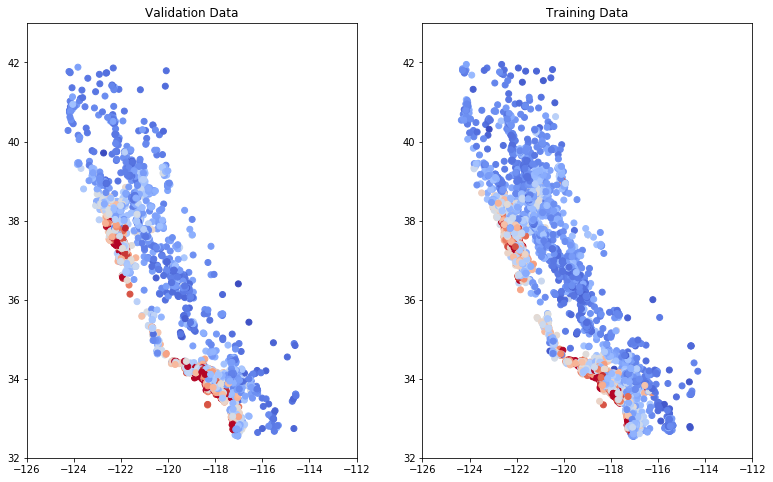

In [36]:
plt.figure(figsize=(13,8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples['longitude'], validation_examples['latitude'], cmap="coolwarm",
           c=validation_targets['median_house_value'] / validation_targets['median_house_value'].max())

ax = plt.subplot(1, 2, 2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples['longitude'], training_examples['latitude'], cmap="coolwarm",
           c=training_targets['median_house_value'] / training_targets['median_house_value'].max())

## Task 3: Return to Data Importing and Pre-Processing code and find bugs

- data isn't randomized

Shuffled data before passing into extraction helper methods

## Task 4: Train and Evaluate Model

In [37]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Train a linear regressor on a single feature
    
    Arg:
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Size of batches to be passed
        num_epochs: Number of epochs for which dat should be repeated.  None = repeat indefinitely
    Returns:
        Tuple of (features,labels) for next data batch
    """
    
    # convert features DataFrame into dict of np arrays
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    # construct dataset, configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # shuffle data, if necessary
    if shuffle:
        ds = ds.shuffle(1000)
        
    # return next batch
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [38]:
def construct_feature_columns(input_features):
    """
    Construct the TensorFlow Feature Columns
    
    Args:
        input_features: Names of the numerical input features to use
    Returns:
        A set of feature columns
    """
    
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [39]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """
    Trains linear regression model
    
    Prints training progress info, training loss, and validation loss
    
    Args:
        learning_rate: A 'float', the learning rate
        steps: A non-zero 'int', total number of training steps.  Training step consists of forward and backwards pass using single batch
        batch_size: A non-zero 'int', size of batch
        training_examples: A 'DataFrame' containing one or more columns from 'california_housing_dataframe' for training
        training_targets: A 'DataFrame', containing one column from 'california_housing_dataframe' to use as targets for training
        validation_examples: A 'DataFrame' containing one or more columns from 'california_housing_dataframe' to use as input features for validation
        validation_targets: A 'DataFrame' containing one column from 'california_housing_dataframe' to use as target for validation
    """
    
    periods = 10
    steps_per_period = steps / periods
    
    # create linear regressor
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples),
                                                    optimizer=my_optimizer)
    
    # create input fn
    training_input_fn = lambda: my_input_fn(training_examples, training_targets['median_house_value'], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets['median_house_value'], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets['median_house_value'], num_epochs=1, shuffle=False)
    
    # train model
    print("Training the model...")
    print("RMSE (training):")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        # train model
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        training_predictions = linear_regressor.predict(predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = linear_regressor.predict(predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # compute training and validation loss
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        
        # print loss
        print("    period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # add loss metrics from this period to list
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished...")
    
    # output graph of loss metrics over periods
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor

Training the model...
RMSE (training):
    period 00 : 184.74
    period 01 : 168.58
    period 02 : 169.26
    period 03 : 179.18
    period 04 : 176.75
    period 05 : 178.69
    period 06 : 171.93
    period 07 : 172.66
    period 08 : 181.18
    period 09 : 183.14
Model training finished...


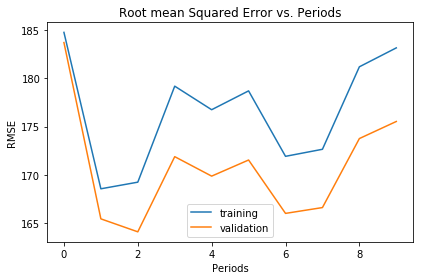

In [42]:
linear_regressor = train_model(
    learning_rate=0.0001,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)